# BIDMC Datathon Question #1
# English vs. Non-English Speaker MIMIC-III Cohort

# Notebook 2: Exploratory Analysis

In this notebook, we want to walk you through some basic steps on how to analyze the cohort which we generated in the first notebook. This notebook is meant to simply introduce a few first steps towards performing an exploratory analysis of the data as you begin building models as performing inference in your teams.

This notebook is just a quick introduction to analyzing the cohort in R. It's up to you and your team to decide what and how you want to analyze the data! 

This is where our paths diverge! Looking forward to seeing where we all end up in the next 3 hours.

# Setup

## Prerequisites

- If you do not have a Gmail account, please create one at http://www.gmail.com. 
- If you have not yet signed the data use agreement (DUA) sent by the organizers, please do so now to get access to the dataset.

## Load libraries

Run the following cells to install and import some libraries.

In [2]:
install.packages("bigrquery")
install.packages("googledrive")
install.packages("R.utils")
install.packages("cowplot")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bit’, ‘bit64’, ‘gargle’, ‘rapidjsonr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [0]:
suppressPackageStartupMessages({
  library(tidyverse)   ## for easy DS in R
  library(cowplot)     ## for plotting plots together
  library(bigrquery)   ## for querying BigQuery
  library(googledrive) ## for read/write Google Drive
  library(httr)        ## for hacking bigrquery to run in Colab
  library(R.utils)     ## ""
  library(repr)        ## for modifying R plot dims in Colab
})

We also set a few global parameters for nicer plots.

In [0]:
## specify default plot dimensions
options(repr.plot.width=4, repr.plot.height=3, repr.plot.res = 300)

## specify default ggplot2 theme
theme_set(theme_bw())

## Connect to Drive

Connecting the Google Colab with Google Drive is relatively straightforward. First, we need to run the following hack to allow R access to Google Drive with the `googledrive` package from a Google Colab notebook.

In [0]:
## source: https://github.com/r-lib/httr/pull/634
reassignInPackage("is_interactive", pkgName = "httr", function() {return(TRUE)})

Next, authenticate your Google account by calling the following command. Follow the link and enter the authorization code in the dialog box.

In [10]:
drive_auth(use_oob = TRUE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/auth?client_id=603366585132-0l3n5tr582q443rnomebdeeo0156b2bc.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code



Enter authorization code: 4/xAF2mwDEScNcMLyQeSOjpJAaD50tjjZLJe__irIav-kkn_A6FvG2Vfc


# Load data

We will now load the dataset from Google Drive. This CSV file should have been created by going through the first notebook in this workshop.

## Download from Drive

First, you can download the file from Google Drive using the `drive_download()` function.

In [11]:
drive_download("dataset_datathon_28022020.csv")

File downloaded:
  * dataset_datathon_28022020.csv
Saved locally as:
  * dataset_datathon_28022020.csv



Verify that the file is now available on our path.

In [13]:
file.exists("dataset_datathon_28022020.csv")

[1] TRUE

## Read from File

Now that we have the CSV file downloaded, we can read the dataset into our Colab.

In [14]:
cohort <- read_csv("dataset_datathon_28022020.csv")

Parsed with column specification:
cols(
  .default = col_double(),
  ethnicity = col_character(),
  marital_status = col_character(),
  religion = col_character(),
  insurance = col_character(),
  diagnosis = col_character(),
  admission_type = col_character(),
  admission_location = col_character(),
  hosp_admittime = col_datetime(format = ""),
  hosp_dischtime = col_datetime(format = ""),
  first_careunit = col_character(),
  icu_intime = col_datetime(format = ""),
  icu_outtime = col_datetime(format = "")
)

See spec(...) for full column specifications.



# Exploratory analysis

The first step in any data analysis should be **exploratory analysis** of the dataset. When performing an exploratory analysis, you should be checking high-level distributions of various covariates, marginal associations, and on the look out for potential messy data issues. 

We can start by just taking a look at the first few rows in the table.

In [15]:
head(cohort)

subject_id,hadm_id,icustay_id,english,age,male,ethnicity,marital_status,religion,insurance,⋯,drug_abuse.y,psychoses.y,depression.y,elixhauser_vanwalraven.y,elixhauser_sid29.y,elixhauser_sid30.y,sepsis_3,sofa,mechvent_event,mechvent_free_days
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
109,189332,287547,1,25.1,0,BLACK/AFRICAN AMERICAN,SINGLE,NOT SPECIFIED,Medicaid,⋯,0,0,0,28,40,46,0,NA,0,NA
111,155897,249202,1,69.0,0,WHITE,MARRIED,PROTESTANT QUAKER,Medicare,⋯,0,0,0,18,29,33,0,NA,1,0.1850810
124,138376,256064,1,75.1,1,WHITE,MARRIED,CATHOLIC,Medicare,⋯,0,0,0,21,25,35,0,NA,1,2.2355208
188,132401,246866,1,56.6,1,WHITE,MARRIED,CATHOLIC,Private,⋯,0,0,0,24,27,35,0,NA,1,1.5448032
305,194340,217232,0,76.9,0,WHITE,MARRIED,CATHOLIC,Medicare,⋯,0,0,0,23,31,37,1,6,0,NA
502,116367,209737,1,50.5,1,WHITE,MARRIED,PROTESTANT QUAKER,Private,⋯,1,0,0,13,20,19,1,11,1,0.1132639


Let's take a quick look at some of the primary columns in our dataset.

## Language

We should start to analyze our cohort and find out if there is a significant relationship between end-of-life treatment between English and non-English speaking patients.

Let's start by just taking a look at how many of the patients in our cohort were labeled as English speakers.

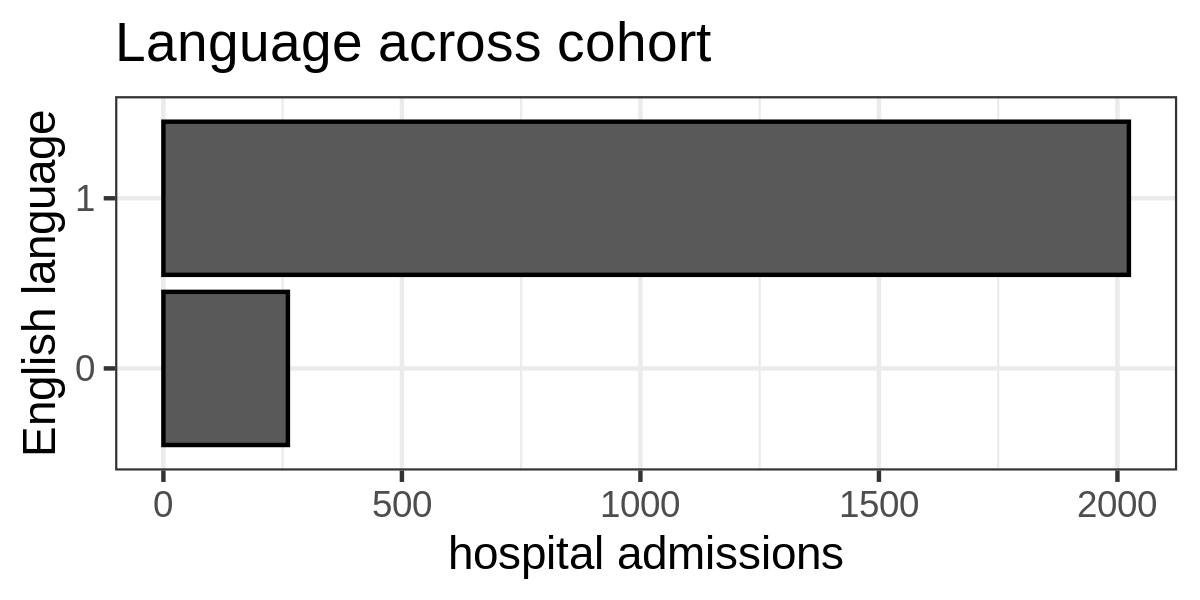

In [0]:
options(repr.plot.width = 4, repr.plot.height = 2)
cohort %>%
    ggplot(aes(x = factor(english))) + 
    geom_bar(color = 'black') + 
    coord_flip() + 
    xlab("English language") + 
    ylab("hospital admissions") + 
    ggtitle("Language across cohort")

It looks like most patients in our cohort spoke English.

We can take a look at how different covariates or outcomes break down between the two groups. Below, we start by taking a look at the ventilation features in our table. After taking a look at this code, consider looking at other columns in our table.

## Ventilation

Let's take a look at some of the ventilation characteristics across patients.

Let's see how many patients were on ventilation during their admission.

In [18]:
cohort %>%
    dplyr::count(mechvent_event) %>%
    dplyr::mutate(p = round(n / sum(n), 4))

mechvent_event,n,p
<dbl>,<int>,<dbl>
0,709,0.3103
1,1576,0.6897


It looks like most patients (almost 70%) were on ventilation.

How do things look if we stratify by patient language?

In [19]:
cohort %>%
    dplyr::count(english, mechvent_event) %>%
    dplyr::group_by(english) %>%
    dplyr::mutate(p = round(n / sum(n), 4))

english,mechvent_event,n,p
<dbl>,<dbl>,<int>,<dbl>
0,0,89,0.3410
0,1,172,0.6590
1,0,620,0.3063
1,1,1404,0.6937


Interesting!

It looks like there were proportionally fewer patients on mechanical ventilation in the non-english speaking subset of the cohort. 

We can also plot this to see it visually. Since the total number of patients in the english and non-english speaking cohorts is fairly different, we will plot the proportions.

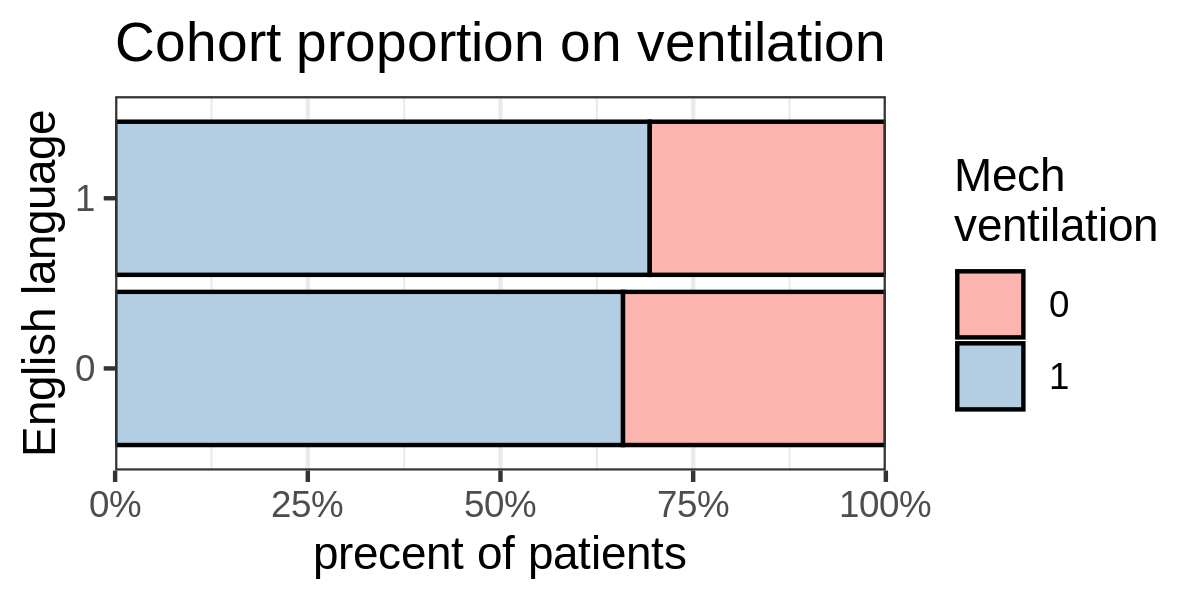

In [0]:
options(repr.plot.width = 4, repr.plot.height = 2)
cohort %>%
    ggplot(aes(x = factor(english), 
               fill = factor(mechvent_event))) + 
    geom_bar(position = "fill", color = 'black') + 
    coord_flip() + 
    xlab("English language") + 
    scale_y_continuous("precent of patients",  labels = scales::percent,
                       expand = c(0, 0)) +
    scale_fill_brewer("Mech\nventilation", palette = "Pastel1") + 
    ggtitle("Cohort proportion on ventilation")

We see a slight different between the populations. However, this **may be due to confounding** or **imbalance in other characteristics** of the populations.

What other features in the table should we take a look at? Which do you think are most important?

# Creating a "Table 1"

In reports or papers for clinical trials or retrospective data studies, you'll often find a cohort summary table presented as _Table 1_. Table 1 describes the cohort's characteristics, such as age, sex, and ethnicity, stratified by the exposure under investigation. Often, the exposure groups are shown as two columns in the table (e.g. group A and group B). Creating these tables can be fairly tedious, especially when the list of potentially confounding covariates is long.

The good news: there are plenty of packages for generating these tables automatically (in both Python _and_ R), so you only need to reshape your dataset, handle missing data (depending on the package) and call the corresponding functions in the respective Python and R libraries.

The following 2 are examples of packages that can be used to generate a "Table 1" in Python and R:

- Python: [Table One](https://pypi.org/project/tableone/)
- R: [Table One](https://cran.r-project.org/web/packages/tableone/vignettes/introduction.html)

In this section of the notebook, consider generating a "Table 1", analyze the results and include it in your final presentation. To do this, however, you first need to define the stratifying exposure or variable (e.g. English vs. non-English speaking) and define the set of covariates (rows) you want to display. 

Keep these things in mind while performing your analysis and consider creating Table 1 and performing exploratory analysis extensively *early on*!